In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split,StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# EDA  (EXPLORATORY DATA ANALYSIS ) #

1. Importación del conjunto de datos

In [2]:
df = pd.read_csv('bbdd_TFM.csv', sep = ';')

2. Visualización general del conjunto de datos

In [3]:
# Tamaño del dataset
df.shape

(69, 11)

In [4]:
# Primeras filas del dataset
df.head()

,Fecha de nacimiento,Date of PET/CT,Histología,MTV_TOTAL,MTV_INFRADIA_TOTAL,GLSUPR_MTV,TLG_TOTAL,TLG_INFRADIA_TOTAL,GLSUPR_TLG,SUVMAX_LIQASC,Enfermedad Residual
0,20/05/1959,07/11/2018,HGSOC,444.85,444.85,0.00,1125.72,1125.72,0.00,2.49,1
1,17/08/1963,19/11/2020,HGSOC,93.84,93.84,0.00,194.30,194.30,0.00,2.70,0
2,04/09/1951,13/02/2020,HGSOC,1173.91,1147.45,26.46,3910.80,3864.79,46.01,2.70,1
3,07/06/1946,12/07/2019,HGSOC,386.84,386.84,0.00,1266.43,1266.43,0.00,1.79,0
4,18/01/1967,15/03/2021,Carcinosarcoma ovárico,248.27,245.45,2.82,376.62,372.59,4.03,0.00,0


In [5]:
# Resumen de variables estadísticas del conjunto de datos
df.describe()

,MTV_TOTAL,MTV_INFRADIA_TOTAL,GLSUPR_MTV,TLG_TOTAL,TLG_INFRADIA_TOTAL,GLSUPR_TLG,SUVMAX_LIQASC,Enfermedad Residual
count,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000
mean,153.600000,152.788261,0.811739,662.680435,660.955797,1.724638,0.437391,0.173913
std,223.857811,221.838439,3.628155,1193.467102,1191.648199,6.750300,1.051089,0.381812
min,0.940000,0.940000,0.000000,3.230000,2.450000,0.000000,0.000000,0.000000
25%,14.120000,14.120000,0.000000,65.940000,63.130000,0.000000,0.000000,0.000000
50%,36.850000,36.850000,0.000000,158.420000,158.420000,0.000000,0.000000,0.000000
75%,248.270000,245.450000,0.000000,819.880000,819.880000,0.000000,0.000000,0.000000
max,1173.910000,1147.450000,26.460000,7824.460000,7824.460000,46.010000,3.900000,1.000000


In [7]:
# Información sobre los tipos de datos y valores nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69 entries, 0 to 68
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Fecha de nacimiento   69 non-null     object 
 1   Date of PET/CT        69 non-null     object 
 2   Histología            69 non-null     object 
 3   MTV_TOTAL             69 non-null     float64
 4   MTV_INFRADIA_TOTAL    69 non-null     float64
 5   GLSUPR_MTV            69 non-null     float64
 6   TLG_TOTAL             69 non-null     float64
 7   TLG_INFRADIA_TOTAL    69 non-null     float64
 8   GLSUPR_TLG            69 non-null     float64
 9   SUVMAX_LIQASC         69 non-null     float64
 10  Enfermedad Residual   69 non-null     int64  
dtypes: float64(7), int64(1), object(3)
memory usage: 6.1+ KB


Se observa que el cojunto de datos no presenta nulos

3. Renombramos la variable objetivo o clase

In [8]:
# Cambiamos la columna enfermdad residual por citoreducion completa
df.rename(columns={'Enfermedad Residual': 'citorreduccion_completa'}, inplace=True)

In [9]:
# Invertimos los valores 1 por 0 y 0 por 1 en la columna
df['citorreduccion_completa'] = df['citorreduccion_completa'].replace({1: 0, 0: 1})

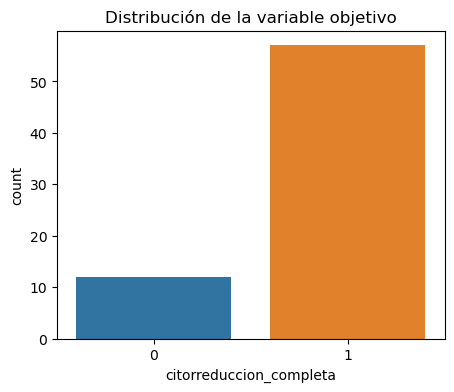

citorreduccion_completa
1    57
0    12
Name: count, dtype: int64


In [10]:
# Visualizamos la distribución de la variable objetivo
plt.figure(figsize=(5, 4))
sns.countplot(x='citorreduccion_completa', data=df)
plt.title('Distribución de la variable objetivo')
plt.show()

recuento = df['citorreduccion_completa'].value_counts()
print(recuento)

Se observa un claro desbalance de la clase, siendo predominante ejemplos donde se ha podido realizar la citorreducción completa de los pacientes

4. Ingeniería de variables

In [11]:
for columna in df.columns:
    print(f"Valores únicos de la columna '{columna}':")
    print(df[columna].unique())
    print("\n")

Valores únicos de la columna 'Fecha de nacimiento ':
['20/05/1959' '17/08/1963' '04/09/1951' '07/06/1946' '18/01/1967'
 '20/06/1975' '28/03/1979' '19/11/1964' '06/10/1947' '09/07/1963'
 '15/10/1956' '01/06/1975' '09/02/1959' '22/09/1967' '18/06/1980'
 '16/04/1975' '14/09/1979' '07/07/1979' '24/12/1959' '27/02/1973'
 '27/06/1950' '12/04/1954' '17/09/1967' '16/06/1969' '13/11/1953'
 '23/10/1961' '16/02/1962' '04/04/1954' '29/01/1958' '24/12/1952'
 '09/04/1982' '14/05/1964' '07/06/1958' '05/04/1955' '06/02/1974'
 '25/12/1976' '15/08/1953' '07/06/1954' '07/06/1972' '21/05/1973'
 '09/01/1948' '06/11/1991' '29/02/1960' '11/06/1965' '04/04/1957'
 '01/07/1957' '01/12/1949' '19/02/1980' '28/08/1957' '24/09/1957'
 '07/11/1946' '27/03/1949' '16/09/1964' '24/12/1958' '21/01/1947'
 '19/04/1964' '22/06/1960' '26/09/1954' '22/10/1964' '24/11/1947'
 '03/02/1984' '02/08/1983' '24/02/1963' '03/05/1982' '26/10/1961'
 '13/12/1966' '01/06/1964']


Valores únicos de la columna 'Date of PET/CT':
['07/11/2018

In [12]:
# Eliminamos espacios en blanco al principio y al final de los nombres de las columnas
df.columns = df.columns.str.strip()

In [13]:
df['Histología'] = df['Histología'].replace({'LGSOC ': 'LGSOC'})

Cálculo de nueva variable 'edad' a partir de las variables 'Fecha de nacimiento' y 'Date of PET/CT'

In [14]:
# Convertir las columnas 'Fecha de nacimiento' y 'Date of PET/CT' a formato de fecha
df['Fecha de nacimiento'] = pd.to_datetime(df['Fecha de nacimiento'],format='%d/%m/%Y')
df['Date of PET/CT'] = pd.to_datetime(df['Date of PET/CT'], format='%d/%m/%Y')

In [15]:
# Calcular la diferencia en años
df['Edad'] = (df['Date of PET/CT'] - df['Fecha de nacimiento']).dt.days // 365

In [16]:
# Se eliminan columnas que no aportan información
df.drop(columns = ['Fecha de nacimiento', 'Date of PET/CT'], inplace=True)

5. Visualización de la distribución de las variables

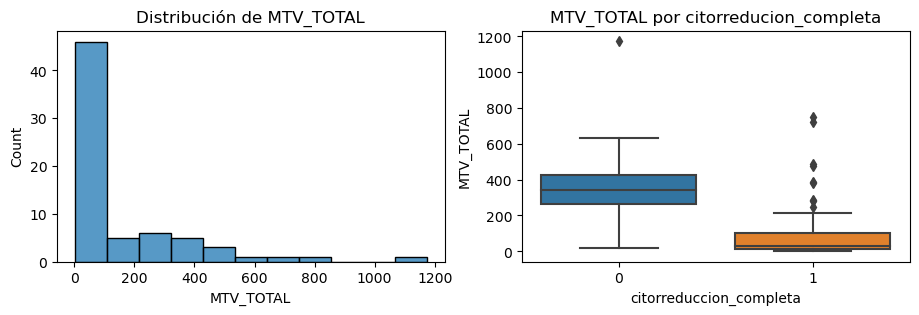

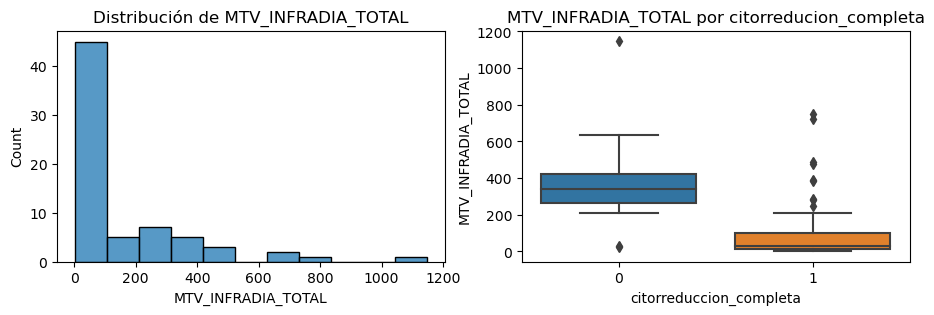

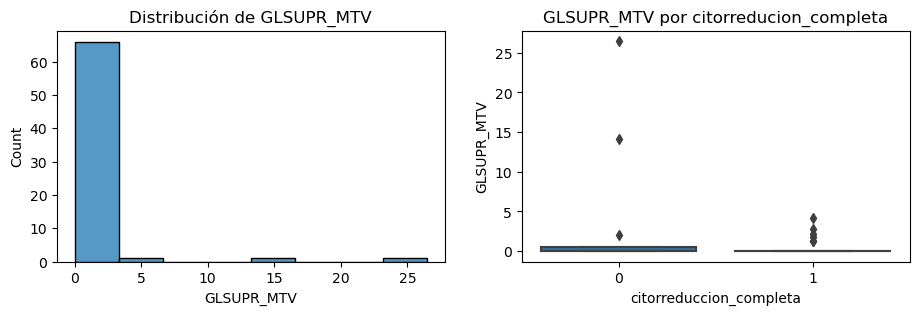

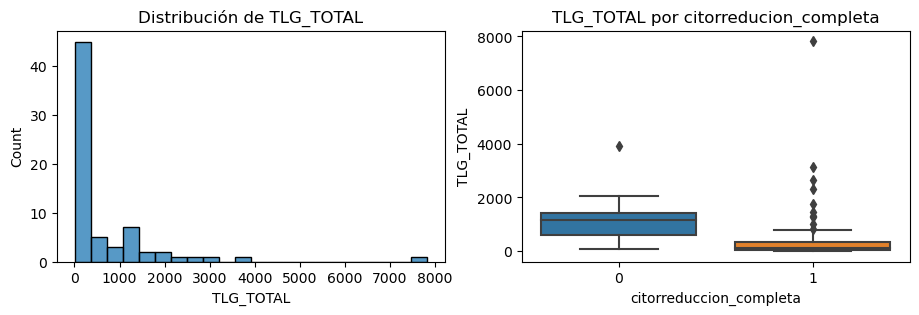

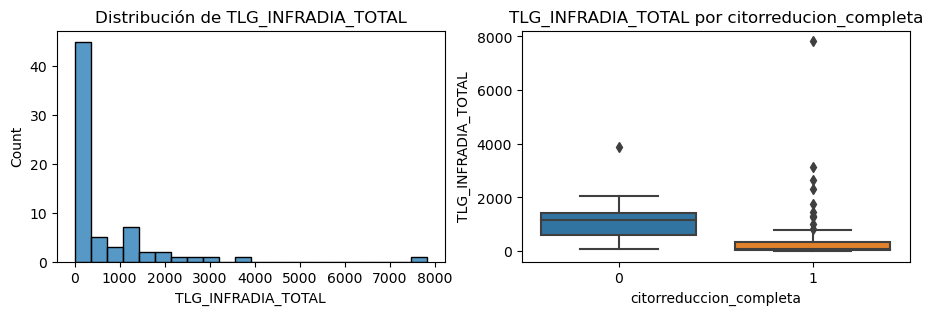

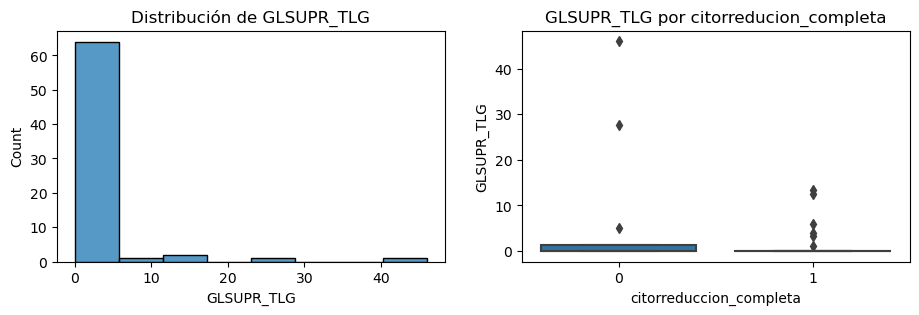

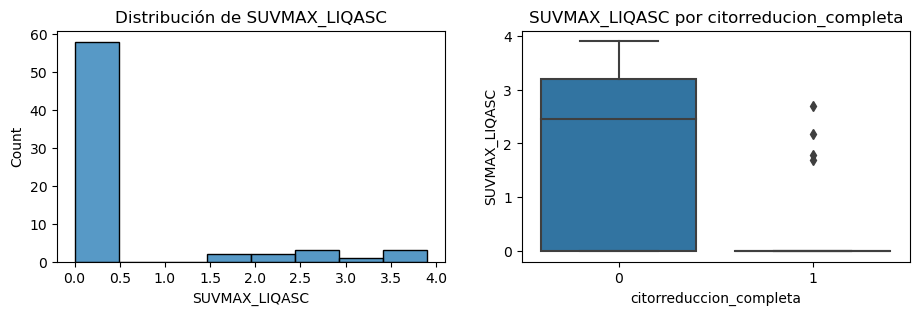

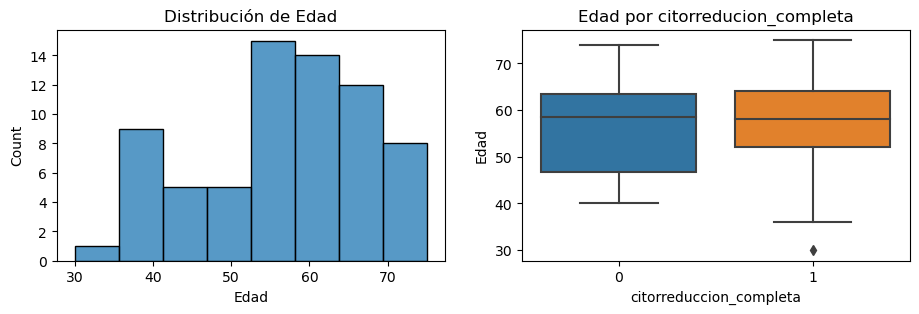

In [22]:
numeric_vars = df.select_dtypes(include = [np.number]).columns.drop('citorreduccion_completa')

for var in numeric_vars:
    plt.figure(figsize = (11, 3))

    # Histograma
    plt.subplot(1, 2, 1)
    sns.histplot(df[var])
    plt.title(f'Distribución de {var}')
    
    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x = 'citorreduccion_completa', y = var, data = df)
    plt.title(f'{var} por citorreducion_completa')

    plt.show()

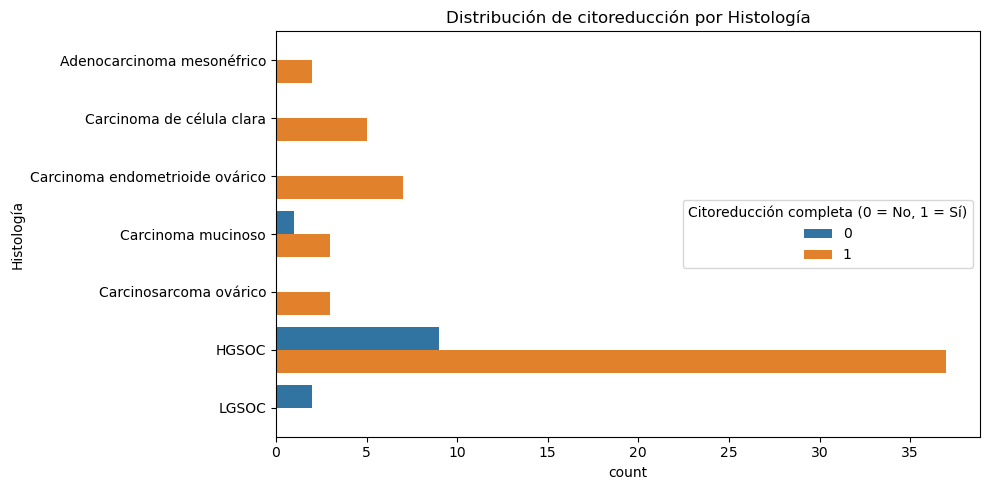

In [20]:
# Crear un nuevo DataFrame que cuenta los pacientes por histología y cito-reducción
histologia_counts = df.groupby(['Histología', 'citorreduccion_completa']).size().reset_index(name='count')

# Configurar el tamaño de la figura
plt.figure(figsize=(10, 5))

# Crear un gráfico de columnas horizontales
sns.barplot(data=histologia_counts, y='Histología', x='count', hue='citorreduccion_completa')

# Añadir etiquetas y título
plt.title('Distribución de citoreducción por Histología')
plt.legend(title='Citoreducción completa (0 = No, 1 = Sí)')

# Ajustar el diseño
plt.tight_layout()

# Mostrar el gráfico
plt.show()

6. Matriz de correlación de las variables numéricas

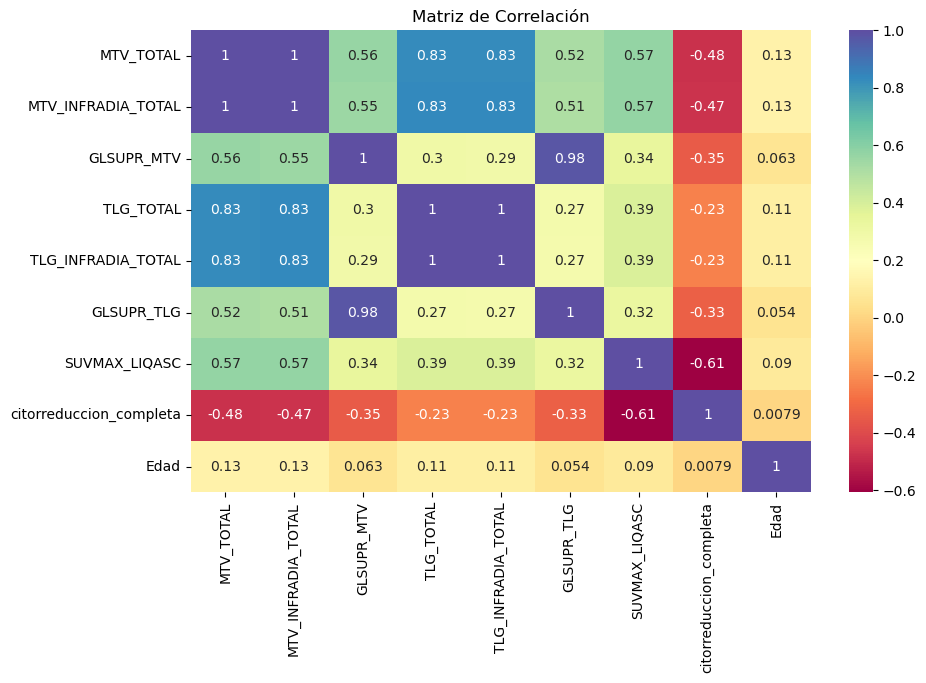

In [23]:
# Filtrar solo las columnas numéricas
numeric_df = df.select_dtypes(include = [np.number])

# Calcular la matriz de correlación
corr_matrix = numeric_df.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot = True, cmap = 'Spectral')
plt.title('Matriz de Correlación')
plt.show()

In [24]:
#Mostrar la correlación con citorreducion_completa para cada variable
for var in numeric_vars:
    correlation = df[[var, 'citorreduccion_completa']].corr().iloc[0, 1]
    print(f"Correlación entre {var} y citorreduccion_completa: {correlation:.2f}")

Correlación entre MTV_TOTAL y citorreduccion_completa: -0.48
Correlación entre MTV_INFRADIA_TOTAL y citorreduccion_completa: -0.47
Correlación entre GLSUPR_MTV y citorreduccion_completa: -0.35
Correlación entre TLG_TOTAL y citorreduccion_completa: -0.23
Correlación entre TLG_INFRADIA_TOTAL y citorreduccion_completa: -0.23
Correlación entre GLSUPR_TLG y citorreduccion_completa: -0.33
Correlación entre SUVMAX_LIQASC y citorreduccion_completa: -0.61
Correlación entre Edad y citorreduccion_completa: 0.01


Se puede observar que prácticamente la totalidad de las variables tienen correlaciónn con la cito reducción

7. Detección de outliers

In [25]:
# Usamos el rango intercuartílico para detectar outliers
outlier_results = []
for var in numeric_vars:
    Q1 = df[var].quantile(0.25)
    Q3 = df[var].quantile(0.75)
    RI = Q3 - Q1
    outliers = df[(df[var] < (Q1 - 1.5 * RI)) | (df[var] > (Q3 + 1.5 * RI))]
    # Añadir el resultado a la lista
    outlier_results.append({'Variable': var, 'Outliers Detectados': outliers.shape[0]})

# Crear un DataFrame con los resultados
outlier_table = pd.DataFrame(outlier_results)

# Mostrar la tabla
(outlier_table)

,Variable,Outliers Detectados
0,MTV_TOTAL,4
1,MTV_INFRADIA_TOTAL,4
2,GLSUPR_MTV,9
3,TLG_TOTAL,6
4,TLG_INFRADIA_TOTAL,6
5,GLSUPR_TLG,9
6,SUVMAX_LIQASC,11
7,Edad,0


Dado el reducido número de pacientes (69 en total), se ha decidido no eliminar ningún outlier en el análisis. En un conjunto de datos clínico tan pequeño, los valores atípicos no necesariamente reflejan ruido o errores, sino que pueden representar variabilidad legítima dentro de la población de estudio. Estos valores podrían estar menos representados simplemente debido al tamaño limitado de la muestra, sin que ello implique que no sean clínicamente relevantes.

Eliminar estos valores extremos podría llevar a la pérdida de información valiosa, especialmente en un contexto clínico. En lugar de ser considerados como anomalías, es posible que los outliers reflejen casos particulares que, lejos de ser ruido, aporten datos esenciales para comprender la heterogeneidad entre los pacientes. Por ejemplo, un valor muy elevado de MTV_total podría ser un fuerte predictor clínico de que no se logrará una citorreducción completa. Ignorar estos casos, únicamente por ser menos comunes, podría privar al análisis de información clave para la toma de decisiones médicas.

En este contexto, los valores extremos suelen tener una importancia clínica significativa. Valores elevados de determinadas variables podrían estar vinculados a condiciones críticas que requieren atención especial y no deben ser descartados sin una evaluación adecuada.

En resumen, debido al pequeño tamaño de la muestra y a la relevancia clínica de los valores extremos, mantener los outliers en el análisis es crucial para capturar toda la variabilidad del conjunto de datos y garantizar que no se pierdan predictores importantes.

8. Pruebas estadísticas. Se va a comproobar si hay diferencias significativas entre ambos grupos

In [26]:
# Lista de variables numéricas sin 'citorreducion_completa'
numeric_vars = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_vars.remove('citorreduccion_completa')

In [27]:
# Grupos de 'citorreducion_completa'
grupo_completa  = df[df['citorreduccion_completa'] == 1]
grupo_no_completa  = df[df['citorreduccion_completa'] == 0]

In [28]:
resultados = []
# Prueba t para cada variable
for var in numeric_vars:
    stat, p_value = ttest_ind(grupo_completa[var], grupo_no_completa[var], equal_var = False)
    
    # Determinar si es estadísticamente significativo
    significativo = "Sí" if p_value < 0.05 else "No"
    # Añadir los resultados a la lista
    resultados.append({'Variable': var, 'P-valor': p_value, 'Estadísticamente Significativo': significativo})
    
# Convertir la lista en un DataFrame
df_resultados = pd.DataFrame(resultados)

df_resultados

,Variable,P-valor,Estadísticamente Significativo
0,MTV_TOTAL,0.008918,Sí
1,MTV_INFRADIA_TOTAL,0.008472,Sí
2,GLSUPR_MTV,0.192553,No
3,TLG_TOTAL,0.043849,Sí
4,TLG_INFRADIA_TOTAL,0.044006,Sí
5,GLSUPR_TLG,0.197491,No
6,SUVMAX_LIQASC,0.005230,Sí
7,Edad,0.948182,No


Se observa por tanto que las diferencias en la mayoria de variables de cada grupo son estadisticamente significativas, lo que nos indica que pueden servir como predictoras para determinar la citorreducción completa

# Generación de datos sintéticos #

Para crear los datos sintéticos a partir del conjunto de datos que tenemos, empleamos Redes neuronales generativas antagónicas (GANs)

La estructura de una GAN es la siguiente:
- Generador (G): Es una red que toma un vector de ruido aleatorio como entrada y genera datos falsos (sintéticos) que tratan de parecerse al conjunto de datos reales.
- Discriminador (D): Es otra red que toma una muestra y trata de diferenciar entre datos reales y datos generados por el generador.

El objetivo del generador es engañar al discriminador produciendo datos que se asemejen lo más posible a los datos reales, mientras que el discriminador trata de mejorar su habilidad para distinguir entre datos reales y sintéticos.

Para ello vamos a recurrir a la librería sdv, que es una librería que permite la creación de este tipo de RRNN de forma sencilla.

In [29]:
from sdv.single_table import CTGANSynthesizer, GaussianCopulaSynthesizer,TVAESynthesizer 
from sdv.metadata import Metadata
from sdv.evaluation.single_table import evaluate_quality, get_column_plot, get_column_pair_plot

Para la creación de los datos, se crea un dataframe que no contenga las columnas de totales, con el fin de evitar problemas en la incoherencia de los datos. Esto es mas sencillo que incluir restricciones a los generadores. Por lo que una vez generado los datos, se añaden las columnas de MTV_TOTAL y TLG_TOTAL

In [31]:
df_clean = df.drop(['MTV_TOTAL', 'TLG_TOTAL'], axis = 1)

Generamos los datos a partir de este dataframe

### Creación del Metadata del dataframe #

In [32]:
# Crea el objeto metadata
metadata = Metadata()

In [33]:
metadata = metadata.detect_from_dataframe(df_clean, table_name = 'pacientes_reales')

### Creación de los generadores

In [70]:
#Creaión del sintetizador CTGAN
modelo_CTGAN = CTGANSynthesizer(metadata, enforce_rounding = True, epochs = 3000)

In [71]:
#Creación del sintetizador GaussianCopula
modelo_COPULA = GaussianCopulaSynthesizer(metadata)

In [72]:
modelo_TVAE = TVAESynthesizer(metadata, enforce_rounding = True, epochs = 2000)

### Se entrenan los generadores

In [73]:
modelo_CTGAN.fit(df_clean)

In [74]:
# Ajusta el modelo a tus datos
modelo_COPULA.fit(df_clean)

In [75]:
modelo_TVAE.fit(df_clean)

### Se generan los datos sintéticos

In [76]:
CTGAN_data = modelo_CTGAN.sample(num_rows=600)

In [77]:
COPULA_data = modelo_COPULA.sample(num_rows=600)

In [78]:
TVAE_data = modelo_TVAE.sample(num_rows = 600)

### Se compara la calidad de los datos generados con la función evaluate_quality

In [79]:
# Verifica los datos generados por CTGAN
quality_report = evaluate_quality(
    df_clean,
    CTGAN_data,
    metadata)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████████████████████████████████████████████████| 8/8 [00:00<00:00, 360.23it/s]|
Column Shapes Score: 68.9%

(2/2) Evaluating Column Pair Trends: |███████████████████████████████████████████████| 28/28 [00:00<00:00, 101.49it/s]|
Column Pair Trends Score: 86.72%

Overall Score (Average): 77.81%



In [80]:
# Verifica los datos generados por COPULA
quality_report = evaluate_quality(
    df_clean,
    COPULA_data,
    metadata)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████████████████████████████████████████████████| 8/8 [00:00<00:00, 290.65it/s]|
Column Shapes Score: 73.52%

(2/2) Evaluating Column Pair Trends: |███████████████████████████████████████████████| 28/28 [00:00<00:00, 109.74it/s]|
Column Pair Trends Score: 83.08%

Overall Score (Average): 78.3%



In [81]:
# Verifica los datos generados por TVAE
quality_report = evaluate_quality(
    df_clean,
    TVAE_data,
    metadata)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████████████████████████████████████████████████| 8/8 [00:00<00:00, 335.94it/s]|
Column Shapes Score: 80.23%

(2/2) Evaluating Column Pair Trends: |███████████████████████████████████████████████| 28/28 [00:00<00:00, 115.33it/s]|
Column Pair Trends Score: 87.29%

Overall Score (Average): 83.76%



### Se comparan visualmente las distribuciones de los datos

In [82]:
from plotly.subplots import make_subplots

# Crear subgráficos con 1 fila y 3 columnas
fig = make_subplots(rows=1, cols=3, subplot_titles=("CTGAN", "COPULA", "TVAE"))

# Agregar el gráfico de CTGAN
fig_ctgan = get_column_plot(
    real_data=df_clean,
    synthetic_data=CTGAN_data,
    column_name='SUVMAX_LIQASC',
    metadata=metadata
)
fig.add_traces(fig_ctgan.data, rows=1, cols=1)

# Agregar el gráfico de COPULA
fig_copula = get_column_plot(
    real_data=df_clean,
    synthetic_data=COPULA_data,
    column_name='SUVMAX_LIQASC',
    metadata=metadata
)
fig.add_traces(fig_copula.data, rows=1, cols=2)

# Agregar el gráfico de TVAE
fig_vae = get_column_plot(
    real_data=df_clean,
    synthetic_data=TVAE_data,
    column_name='SUVMAX_LIQASC',
    metadata=metadata
)
fig.add_traces(fig_vae.data, rows=1, cols=3)

# Añadir un título general a la figura
fig.update_layout(
    title_text="Distribución de SUVMAX_LIQASC de cada generador",
    title_x=0.5, # Centrar el título
    height=400
)

# Mostrar la figura combinada
fig.show()

In [83]:
from plotly.subplots import make_subplots

# Crear subgráficos con 1 fila y 3 columnas
fig = make_subplots(rows=1, cols=3, subplot_titles=("CTGAN", "COPULA", "TVAE"))

# Agregar el gráfico de CTGAN
fig_ctgan = get_column_plot(
    real_data=df_clean,
    synthetic_data=CTGAN_data,
    column_name='MTV_INFRADIA_TOTAL',
    metadata=metadata
)
fig.add_traces(fig_ctgan.data, rows=1, cols=1)

# Agregar el gráfico de COPULA
fig_copula = get_column_plot(
    real_data=df_clean,
    synthetic_data=COPULA_data,
    column_name='MTV_INFRADIA_TOTAL',
    metadata=metadata
)
fig.add_traces(fig_copula.data, rows=1, cols=2)

# Agregar el gráfico de TVAE
fig_vae = get_column_plot(
    real_data=df_clean,
    synthetic_data=TVAE_data,
    column_name='MTV_INFRADIA_TOTAL',
    metadata=metadata
)
fig.add_traces(fig_vae.data, rows=1, cols=3)

# Añadir un título general a la figura
fig.update_layout(
    title_text="Distribución de MTV_INFRADIA_TOTAL de cada generador",
    title_x=0.5, # Centrar el título
    height=400
)

# Mostrar la figura combinada
fig.show()

In [84]:
# Crear subgráficos con 1 fila y 3 columnas
fig = make_subplots(rows=1, cols=3, subplot_titles=("CTGAN", "COPULA", "TVAE"))

# Agregar el gráfico de CTGAN
fig_ctgan = get_column_plot(
    real_data=df_clean,
    synthetic_data=CTGAN_data,
    column_name='citorreduccion_completa',
    metadata=metadata
)
fig.add_traces(fig_ctgan.data, rows=1, cols=1)

# Agregar el gráfico de COPULA
fig_copula = get_column_plot(
    real_data=df_clean,
    synthetic_data=COPULA_data,
    column_name='citorreduccion_completa',
    metadata=metadata
)
fig.add_traces(fig_copula.data, rows=1, cols=2)

# Agregar el gráfico de TVAE
fig_vae = get_column_plot(
    real_data=df_clean,
    synthetic_data=TVAE_data,
    column_name='citorreduccion_completa',
    metadata=metadata
)
fig.add_traces(fig_vae.data, rows=1, cols=3)

# Añadir un título general a la figura
fig.update_layout(
    title_text="Distribución de SUVMAX_LIQASC de cada generador",
    title_x=0.5, # Centrar el título
    height=400
)

# Mostrar la figura combinada
fig.show()

In [85]:
# Crear subgráficos con 1 fila y 2 columnas
fig = make_subplots(rows=1, cols=3, subplot_titles=("CTGAN", "COPULA", "VAE"))

# Agregar el gráfico de CTGAN
fig_ctgan = get_column_pair_plot(
    real_data=df_clean,
    synthetic_data=CTGAN_data,
    metadata=metadata,
    column_names=['MTV_INFRADIA_TOTAL', 'TLG_INFRADIA_TOTAL']
)
fig.add_traces(fig_ctgan.data, rows=1, cols=1)

# Agregar el gráfico de COPULA
fig_copula = get_column_pair_plot(
    real_data=df_clean,
    synthetic_data=COPULA_data,
    metadata=metadata,
    column_names=['MTV_INFRADIA_TOTAL', 'TLG_INFRADIA_TOTAL']
)
fig.add_traces(fig_copula.data, rows=1, cols=2)


# Agregar el gráfico de VAE
fig_vae = get_column_pair_plot(
    real_data=df_clean,
    synthetic_data=TVAE_data,
    metadata=metadata,
    column_names=['MTV_INFRADIA_TOTAL', 'TLG_INFRADIA_TOTAL']
)
fig.add_traces(fig_vae.data, rows=1, cols=3)

# Añadir un título general a la figura
fig.update_layout(
    title_text="SCATTER-PLOT MTV-TLG",
    title_x=0.5, # Centrar el título
    height=400
)
# Mostrar la figura combinada
fig.show()

In [86]:
# Crear subgráficos con 1 fila y 3 columnas
fig = make_subplots(rows=1, cols=3, subplot_titles=("CTGAN", "COPULA", "VAE"))

# Agregar el gráfico de CTGAN
fig_ctgan = get_column_pair_plot(
    real_data=df_clean,
    synthetic_data=CTGAN_data,
    metadata=metadata,
    column_names=['MTV_INFRADIA_TOTAL', 'SUVMAX_LIQASC']
)
fig.add_traces(fig_ctgan.data, rows=1, cols=1)

# Agregar el gráfico de COPULA
fig_copula = get_column_pair_plot(
    real_data=df_clean,
    synthetic_data=COPULA_data,
    metadata=metadata,
    column_names=['MTV_INFRADIA_TOTAL', 'SUVMAX_LIQASC']
)
fig.add_traces(fig_copula.data, rows=1, cols=2)


# Agregar el gráfico de VAE
fig_vae = get_column_pair_plot(
    real_data=df_clean,
    synthetic_data=TVAE_data,
    metadata=metadata,
    column_names=['MTV_INFRADIA_TOTAL', 'SUVMAX_LIQASC']
)
fig.add_traces(fig_vae.data, rows=1, cols=3)

# Añadir un título general a la figura
fig.update_layout(
    title_text="SCATTER-PLOT MTV-SUVMAX_LIQASC",
    title_x=0.5, # Centrar el título
    height=400
)

# Mostrar la figura combinada
fig.show()

### Se añaden los totales 

Como se ha observado los datos generados por el generador basado en GANs arroja mejores resultados, por que finalmente estos datos son los elegidos para desarrollar la comparación de los modelos predictivos.

In [87]:
CTGAN_data['MTV_TOTAL'] = CTGAN_data['MTV_INFRADIA_TOTAL'] + CTGAN_data['GLSUPR_MTV']
CTGAN_data['TLG_TOTAL'] = CTGAN_data['TLG_INFRADIA_TOTAL'] + CTGAN_data['GLSUPR_TLG']

Se guarda el dataset para mantener la reproducibilidad de los resultados

In [159]:
CTGAN_data.to_csv('datos_sinteticos.csv', index=False)

# Procesamiento de los datos y preparación de modelos

In [3]:
import pandas as pd

In [88]:
url_sinteticos = 'https://raw.githubusercontent.com/Payer09/TFM/refs/heads/main/datos_sinteticos.csv?token=GHSAT0AAAAAAC2SBFBHZR2YM7RFR24ERA7WZ2DAKPA'

In [89]:
ds = pd.read_csv('datos_sinteticos.csv')

In [90]:
ds

,Histología,MTV_INFRADIA_TOTAL,GLSUPR_MTV,TLG_INFRADIA_TOTAL,GLSUPR_TLG,SUVMAX_LIQASC,citorreduccion_completa,Edad,MTV_TOTAL,TLG_TOTAL
0,HGSOC,15.23,0.00,101.17,0.00,0.13,1,64,15.23,101.17
1,Carcinoma mucinoso,685.38,0.00,2147.65,0.00,0.03,0,52,685.38,2147.65
2,HGSOC,18.52,0.00,344.93,0.00,0.04,1,53,18.52,344.93
3,HGSOC,1147.45,26.46,7697.97,39.29,2.76,0,75,1173.91,7737.26
4,HGSOC,502.35,0.13,1987.76,0.11,3.04,0,54,502.48,1987.87
...,...,...,...,...,...,...,...,...,...,...
595,HGSOC,20.80,0.00,408.33,0.00,0.00,1,50,20.80,408.33
596,Carcinosarcoma ovárico,276.11,3.02,692.05,8.03,0.00,1,68,279.13,700.08
597,Carcinoma mucinoso,45.25,0.17,693.85,0.00,0.00,0,55,45.42,693.85
598,HGSOC,441.90,0.11,2155.92,0.15,0.03,0,47,442.01,2156.07


Creamos un dataframe para guardar las métricas calculadas por cada uno de los modelos

In [103]:
# Creamos un dataframe para almacenar métricas
metrics_df = pd.DataFrame(columns=['Model', 'F1-Score', 'False Negative Rate', 'AUC-ROC', 'Puntuación modelo'])

In [104]:
# Definimos una función para asignar la puntuación a un modelo
def puntuacion_modelo(FNR, f1_score, auc_roc):
    # Asignamos los pesos según la importancia de cada métrica
    peso_fnr = 7
    peso_f1 = 1.5
    peso_auc = 1.5
    
    # Calculamos la puntuación
    puntuacion = 10 - ((FNR * peso_fnr) + ((1 - f1_score) * peso_f1) + ((1 - auc_roc) * peso_auc))
    
    return puntuacion

## 1. Regresión Logística

1. Importamos las bibliotecas

In [91]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, confusion_matrix, f1_score, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

2. Dividimos en variables predictoras y variable objetivo

In [92]:
# Variable objetivo y características
X_rl = ds.drop(columns = ['citorreduccion_completa'])
y_rl = ds['citorreduccion_completa']

3. Definimos un preprocesador de los datos

In [93]:
# Identificar columnas
categorical_cols_rl = ['Histología']
numerical_cols_rl = X_rl.select_dtypes(include = ['float64', 'int64']).columns.tolist()

# Preprocesador para Regresión Logística, en él creamos un pipeline para transformar los datos
preprocessor_rl = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('scaler', StandardScaler())  # Escalamos las variables numéricas
        ]), numerical_cols_rl),
        ('cat', Pipeline(steps=[
            ('onehot', OneHotEncoder(drop='first'))  # Codificación One-Hot
        ]), categorical_cols_rl)
    ]
)

4. Creamos el pipeline

In [94]:
Modelo_rl = LogisticRegression(
    solver = 'saga',
    random_state = 1,
    class_weight = 'balanced',
    penalty = 'l2',
    C = 0.01
)

In [95]:
# Pipeline completo con el modelo de regresión logística
pipeline_rl = Pipeline(steps=[
    ('preprocessor', preprocessor_rl),  # Preprocesamiento
    ('classifier', Modelo_rl)  # Modelo
])

5. Usamos k-fold cross validation

In [96]:
# Configurar k-fold estratificado
k_rl = 5  # Número de pliegues
skf_rl = StratifiedKFold(n_splits = k_rl, shuffle = True, random_state = 1)

6. Usamos la validación cruzada estratificada para realizar las predicciones

In [97]:
# K-fold Cross-validation para obtener las predicciones
y_pred_rl = cross_val_predict(pipeline_rl, X_rl, y_rl, cv = skf_rl, method = "predict")
y_pred_proba_rl = cross_val_predict(pipeline_rl, X_rl, y_rl, cv = skf_rl, method = "predict_proba")[:, 1]

7. Calculamos la matriz de confusión y las métricas. Visualizamos el informe de clasificación

In [98]:
# Calcular la matriz de confusión
cm_rl = confusion_matrix(y_rl, y_pred_rl)

In [99]:
# F1-score
f1_rl = f1_score(y_rl, y_pred_rl, average='macro')

In [100]:
# Cálculo de FNR para cada clase
fnr_rl_class_1 = cm_rl[1, 0] / (cm_rl[1, 0] + cm_rl[1, 1])  # Clase positiva: FN / (FN + TP)
fnr_rl_class_0 = cm_rl[0, 1] / (cm_rl[0, 1] + cm_rl[0, 0])  # Clase negativa: FN / (FN + TP)

# Media simple de los FNR
fnr_rl = (fnr_rl_class_1 + fnr_rl_class_0) / 2

In [101]:
# AUC-ROC ya es independiente de por si del desbalance
fpr_rl, tpr_rl, thresholds_rl = roc_curve(y_rl, y_pred_proba_rl)
roc_auc_rl = auc(fpr_rl, tpr_rl)

In [105]:
# Se calcula la puntuación en base a la función definida
score_rl = puntuacion_modelo(fnr_rl, f1_rl, roc_auc_rl)

In [106]:
# Generar el informe de clasificación
print("Informe de clasificación:")
print(classification_report(y_rl, y_pred_rl))

Informe de clasificación:
              precision    recall  f1-score   support

           0       0.79      0.90      0.84       164
           1       0.96      0.91      0.93       436

    accuracy                           0.91       600
   macro avg       0.87      0.91      0.89       600
weighted avg       0.91      0.91      0.91       600



8. Graficamos la matriz de confusión y la curva ROC

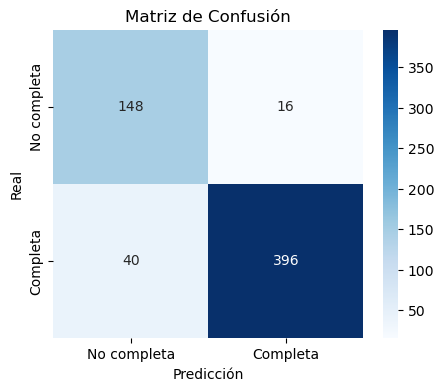

In [107]:
# Graficar la matriz de confusión con seaborn
plt.figure(figsize=(5, 4))
sns.heatmap(cm_rl, annot=True, fmt='g', cmap='Blues', xticklabels=["No completa", "Completa"], yticklabels=["No completa", "Completa"])
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

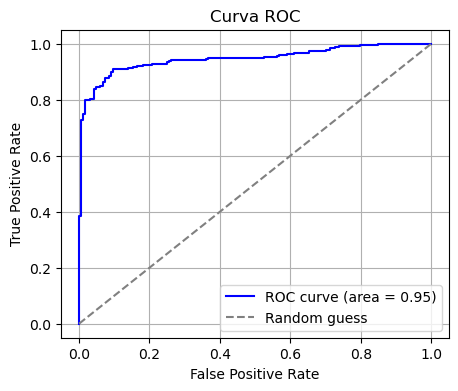

In [108]:
# Graficar la curva ROC
plt.figure(figsize=(5, 4))
plt.plot(fpr_rl, tpr_rl, color='blue', label=f'ROC curve (area = {roc_auc_rl:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

9. Mostramos las métricas el modelo

In [109]:
# Mostrar las métricas del modelo
print(f"F1-Score: {f1_rl:.3f}")
print(f"False Negative Rate: {fnr_rl:.3f}")
print(f"AUC-ROC: {roc_auc_rl:.3f}")
print(f"Puntuacion: {score_rl:.3f}")

F1-Score: 0.887
False Negative Rate: 0.095
AUC-ROC: 0.946
Puntuacion: 9.087


10. Añadimos al dataframe de resultados para comparar los modelos

In [110]:
new_row = pd.DataFrame({
    'Model': ['Regresión lineal'],
    'F1-Score': [round(f1_rl, 3)],
    'False Negative Rate': [round(fnr_rl, 3)],
    'AUC-ROC': [round(roc_auc_rl, 3)],
    'Puntuación modelo': [round(score_rl, 3)]
})

metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

In [111]:
metrics_df

,Model,F1-Score,False Negative Rate,AUC-ROC,Puntuación modelo
0,Regresión lineal,0.887,0.095,0.946,9.087


# 2. SVM

In [27]:
ds = pd.read_csv('datos_sinteticos.csv')

1. Importamos bibliotecas

In [115]:
from sklearn.svm import SVC

2. Dividimos en variables predictoras y objetivo

In [116]:
# Variable objetivo y características
X_svm = ds.drop(columns = ['citorreduccion_completa'])  # Características
y_svm = ds['citorreduccion_completa']  # Variable objetivo

3. Definimos el preprocesador

In [117]:
# Identificar columnas
categorical_cols_svm = ['Histología']
numerical_cols_svm = X_svm.select_dtypes(include = ['float64', 'int64']).columns.tolist()

# Preprocesador para Regresión Logística, en él creamos un pipeline para transformar los datos
preprocessor_svm = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('scaler', StandardScaler())  # Escalamos las variables numéricas
        ]), numerical_cols_svm),
        ('cat', Pipeline(steps=[
            ('onehot', OneHotEncoder(drop='first'))  # Codificación One-Hot
        ]), categorical_cols_svm)
    ]
)

4. Creamos el pipeline

In [118]:
modelo_SVM = SVC(
    kernel = 'rbf', 
    random_state = 1, 
    class_weight = 'balanced', 
    probability = True, 
    C = 0.01)

In [119]:
pipeline_svm = Pipeline(steps=[
    ('preprocessor', preprocessor_svm),  # Preprocesamiento de datos
    ('classifier', modelo_SVM)  # Modelo SVM con regularización
])

5. Creamos la validación cruzada estratificada

In [120]:
# Configurar k-fold estratificado
k_svm = 5  # Número de pliegues
skf_svm = StratifiedKFold(n_splits = k_svm, shuffle = True, random_state = 1)

6. Usamos la validación cruzada estratificada para realizar las predicciones

In [121]:
# Cross-validation para obtener las predicciones
y_pred_svm = cross_val_predict(pipeline_svm, X_svm, y_svm, cv = skf_svm, method = "predict")
y_pred_proba_svm = cross_val_predict(pipeline_svm, X_svm, y_svm, cv = skf_svm, method = "predict_proba")[:, 1]

7. Calculamos la matriz de confusión y las métricas. Visualizamos el informe de clasificación

In [122]:
# Calcular la matriz de confusión
cm_svm = confusion_matrix(y_rl, y_pred_svm)

In [123]:
# F1-score
f1_svm = f1_score(y_rl, y_pred_svm, average='macro')

In [124]:
# Cálculo de FNR para cada clase
fnr_svm_class_1 = cm_svm[1, 0] / (cm_svm[1, 0] + cm_svm[1, 1])  # Clase positiva: FN / (FN + TP)
fnr_svm_class_0 = cm_svm[0, 1] / (cm_svm[0, 1] + cm_svm[0, 0])  # Clase negativa: FN / (FN + TP)

# Media simple de los FNR
fnr_svm = (fnr_svm_class_1 + fnr_svm_class_0) / 2

In [125]:
# Calcular la curva ROC y AUC-ROC
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_rl, y_pred_proba_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

In [126]:
# Se calcula la puntuación en base a la función definida
score_svm = puntuacion_modelo(fnr_svm, f1_svm, roc_auc_svm)

In [127]:
# Generar el informe de clasificación
print("Informe de clasificación SVM:")
print(classification_report(y_svm, y_pred_svm))

Informe de clasificación SVM:
              precision    recall  f1-score   support

           0       0.71      0.96      0.82       164
           1       0.98      0.85      0.91       436

    accuracy                           0.88       600
   macro avg       0.85      0.91      0.86       600
weighted avg       0.91      0.88      0.89       600



8. Graficamos la matriz de confusión y la curva ROC

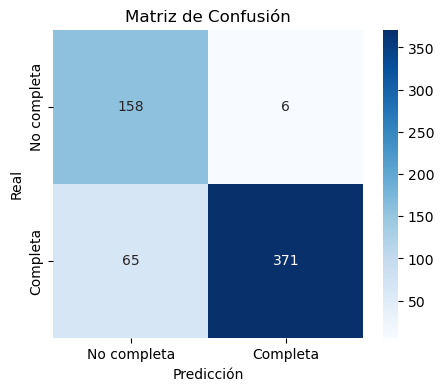

In [128]:
# Graficar la matriz de confusión con seaborn
plt.figure(figsize=(5, 4))
sns.heatmap(cm_svm, annot=True, fmt='g', cmap='Blues', xticklabels=["No completa", "Completa"], yticklabels=["No completa", "Completa"])
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

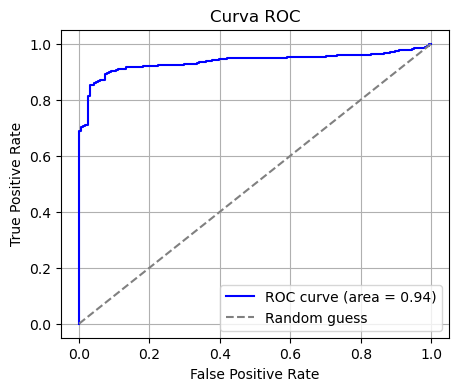

In [129]:
# Graficar la curva ROC
plt.figure(figsize=(5, 4))
plt.plot(fpr_svm, tpr_svm, color='blue', label=f'ROC curve (area = {roc_auc_svm:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

9. Mostramos las métricas del modelo

In [130]:
# Mostrar las métricas del modelo
print(f"F1-Score: {f1_svm:.3f}")
print(f"False Negative Rate: {fnr_svm:.3f}")
print(f"AUC-ROC: {roc_auc_svm:.3f}")
print(f"Puntuacion: {score_svm:.3f}")

F1-Score: 0.865
False Negative Rate: 0.093
AUC-ROC: 0.936
Puntuacion: 9.051


10. Agregamos las métricas al dataframe con redondeo

In [131]:
# Agregar las métricas al DataFrame con redondeo
new_row = pd.DataFrame({
    'Model': ['SVM'],
    'F1-Score': [round(f1_svm, 3)],
    'False Negative Rate': [round(fnr_svm, 3)],
    'AUC-ROC': [round(roc_auc_svm, 3)],
    'Puntuación modelo': [round(score_svm, 3)]
})

# Concatenar la nueva fila al DataFrame existente
metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

In [132]:
metrics_df

,Model,F1-Score,False Negative Rate,AUC-ROC,Puntuación modelo
0,Regresión lineal,0.887,0.095,0.946,9.087
1,SVM,0.865,0.093,0.936,9.051


# 3. KNN

In [149]:
ds = pd.read_csv('datos_sinteticos.csv')

1. Importamos las bibliotecas

In [150]:
from sklearn.neighbors import KNeighborsClassifier

2. Dividimos entre variables predictoras y variable objetivo

In [151]:
# Variable objetivo y características
X_knn = ds.drop(columns = ['citorreduccion_completa'])  # Características
y_knn = ds['citorreduccion_completa']  # Variable objetivo

3. Definimos el preprocesador

In [152]:
# Identificar columnas
categorical_cols_knn = ['Histología']
numerical_cols_knn = X_knn.select_dtypes(include = ['float64', 'int64']).columns.tolist()

# Preprocesador para KNN, en él creamos un pipeline para transformar los datos
preprocessor_knn = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('scaler', StandardScaler())  # Escalamos las variables numéricas
        ]), numerical_cols_knn),
        ('cat', Pipeline(steps=[
            ('onehot', OneHotEncoder(drop='first'))  # Codificación One-Hot
        ]), categorical_cols_knn)
    ]
)

4. Creamos el pipeline

In [153]:
modelo_KNN = KNeighborsClassifier(
    metric = 'euclidean',
    n_neighbors = 6,
    weights = 'uniform',
    algorithm = 'auto')

In [154]:
pipeline_knn = Pipeline(steps=[
    ('preprocessor', preprocessor_knn),  # Preprocesamiento de datos
    ('classifier', modelo_KNN)  # Modelo KNN
])

5. Creamos la validación cruzada estratificada de k pliegues

In [155]:
# Configurar k-fold estratificado
k_knn = 5  # Número de pliegues
skf_knn = StratifiedKFold(n_splits = k_knn, shuffle = True, random_state = 1)

6. Usamos la validación cruzada estratificada para realizar las predicciones

In [156]:
# Cross-validation para obtener las predicciones con KNN
y_pred_knn = cross_val_predict(pipeline_knn, X_knn, y_knn, cv = skf_knn, method = "predict")
y_pred_proba_knn = cross_val_predict(pipeline_knn, X_knn, y_knn, cv = skf_knn, method = "predict_proba")[:, 1]

7. Calculamos la matriz de confusión y las métricas. Visualizamos el informe de clasificación

In [157]:
# Calcular la matriz de confusión
cm_knn = confusion_matrix(y_knn, y_pred_knn)

In [158]:
# F1-score
f1_knn = f1_score(y_knn, y_pred_knn, average='macro')

In [159]:
# Cálculo de FNR para cada clase
fnr_knn_class_1 = cm_knn[1, 0] / (cm_knn[1, 0] + cm_knn[1, 1])  # Clase positiva: FN / (FN + TP)
fnr_knn_class_0 = cm_knn[0, 1] / (cm_knn[0, 1] + cm_knn[0, 0])  # Clase negativa: FN / (FN + TP)

# Media simple de los FNR
fnr_knn = (fnr_knn_class_1 + fnr_knn_class_0) / 2

In [160]:
# Cálculo de la curva ROC y AUC
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_knn, y_pred_proba_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)

In [161]:
# Se calcula la puntuación en base a la función definida
score_knn = puntuacion_modelo(fnr_knn, f1_knn, roc_auc_knn)

In [162]:
# Generar el informe de clasificación
print("Informe de clasificación KNN:")
print(classification_report(y_knn, y_pred_knn))

Informe de clasificación KNN:
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       164
           1       0.96      0.93      0.94       436

    accuracy                           0.92       600
   macro avg       0.89      0.91      0.90       600
weighted avg       0.92      0.92      0.92       600



8. Graficamos la matriz de confusión y la curva ROC

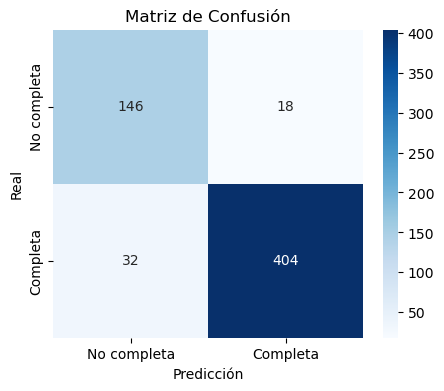

In [163]:
# Graficar la matriz de confusión con seaborn
plt.figure(figsize=(5, 4))
sns.heatmap(cm_knn, annot=True, fmt='g', cmap='Blues', xticklabels=["No completa", "Completa"], yticklabels=["No completa", "Completa"])
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")  
plt.show()

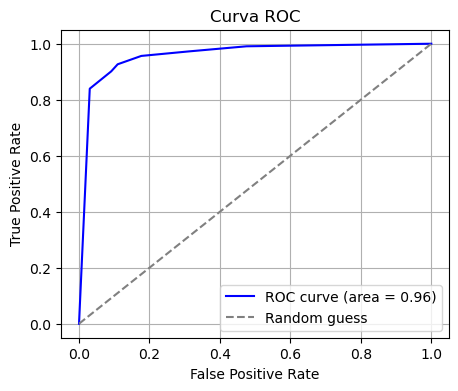

In [164]:
# Graficar la curva ROC
plt.figure(figsize=(5, 4))
plt.plot(fpr_knn, tpr_knn, color='blue', label=f'ROC curve (area = {roc_auc_knn:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

9. Mostramos las métricas del modelo

In [165]:
# Mostrar las métricas del modelo
print(f"F1-Score: {f1_knn:.3f}")
print(f"False Negative Rate: {fnr_knn:.3f}")
print(f"AUC-ROC: {roc_auc_knn:.3f}")
print(f"Puntuacion: {score_knn:.3f}")

F1-Score: 0.898
False Negative Rate: 0.092
AUC-ROC: 0.959
Puntuacion: 9.144


10. Agregamos las métricas al dataframe con redondeo

In [166]:
# Agregar las métricas al DataFrame con redondeo
new_row = pd.DataFrame({
    'Model': ['KNN'],
    'F1-Score': [round(f1_knn, 3)],
    'False Negative Rate': [round(fnr_knn, 3)],
    'AUC-ROC': [round(roc_auc_knn, 3)],
    'Puntuación modelo': [round(score_knn, 3)]
})

# Concatenar la nueva fila al DataFrame existente
metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

In [167]:
metrics_df

,Model,F1-Score,False Negative Rate,AUC-ROC,Puntuación modelo
0,Regresión lineal,0.887,0.095,0.946,9.087
1,SVM,0.865,0.093,0.936,9.051
2,KNN,0.898,0.092,0.959,9.144


# 4. Random Forest Classifier

In [65]:
# Leer los datos
ds = pd.read_csv('datos_sinteticos.csv')

1. Importamos las bibliotecas

In [168]:
from sklearn.ensemble import RandomForestClassifier

2. Dividimos variables predictoras y variable objetivo

In [169]:
# Variable objetivo y características
X_rf = ds.drop(columns = ['citorreduccion_completa'])  # Características
y_rf = ds['citorreduccion_completa']  # Variable objetivo

3. Definimos el preprocesador

In [170]:
# Identificar columnas
categorical_cols_rf = ['Histología']
numerical_cols_rf = X_rf.select_dtypes(include = ['float64', 'int64']).columns.tolist()

# Preprocesador para Random Forest, en él creamos un pipeline para transformar los datos
preprocessor_rf = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('scaler', StandardScaler())  # Escalamos las variables numéricas
        ]), numerical_cols_rf),
        ('cat', Pipeline(steps=[
            ('onehot', OneHotEncoder(drop='first'))  # Codificación One-Hot
        ]), categorical_cols_rf)
    ]
)

4. Creamos el pipeline

In [171]:
modelo_RF = RandomForestClassifier(
    criterion = 'entropy',
    n_estimators = 200, 
    max_depth = 7,
    max_features = 'log2',
    min_samples_leaf = 3,
    random_state = 1,
    bootstrap = True,
    class_weight = 'balanced')

In [172]:
# Crear el pipeline para el modelo Random Forest
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor_rf),  # Preprocesamiento de datos
    ('classifier', modelo_RF)  # Modelo Random Forest
])

5. Configuramos la validación cruzada estratificada de k-pliegues

In [173]:
# Configurar k-fold estratificado
k_rf = 5  # Número de pliegues
skf_rf = StratifiedKFold(n_splits = k_rf, shuffle = True, random_state=1)

6. Usamos la validación cruzada estratificada para realizar las predicciones

In [174]:
# Cross-validation para obtener las predicciones con Random Forest
y_pred_rf = cross_val_predict(pipeline_rf, X_rf, y_rf, cv = skf_rf, method = "predict")
y_pred_proba_rf = cross_val_predict(pipeline_rf, X_rf, y_rf, cv = skf_rf, method = "predict_proba")[:, 1]

7. Calculamos la matriz de confusión y las métricas. Visualizamos el informe de clasificación

In [175]:
# Calcular la matriz de confusión
cm_rf = confusion_matrix(y_rf, y_pred_rf)

In [176]:
# F1-score
f1_rf = f1_score(y_rf, y_pred_rf, average='macro')

In [177]:
# Cálculo de FNR para cada clase
fnr_rf_class_1 = cm_rf[1, 0] / (cm_rf[1, 0] + cm_rf[1, 1])  # Clase positiva: FN / (FN + TP)
fnr_rf_class_0 = cm_rf[0, 1] / (cm_rf[0, 1] + cm_rf[0, 0])  # Clase negativa: FN / (FN + TP)

# Media simple de los FNR
fnr_rf = (fnr_rf_class_1 + fnr_rf_class_0) / 2

In [178]:
# Cálculo de la curva ROC y AUC
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_rf, y_pred_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

In [179]:
# Se calcula la puntuación en base a la función definida
score_rf = puntuacion_modelo(fnr_rf, f1_rf, roc_auc_rf)

In [180]:
# Generar el informe de clasificación
print("Informe de clasificación Random Forest:")
print(classification_report(y_rf, y_pred_rf))

Informe de clasificación Random Forest:
              precision    recall  f1-score   support

           0       0.80      0.91      0.85       164
           1       0.97      0.91      0.94       436

    accuracy                           0.91       600
   macro avg       0.88      0.91      0.90       600
weighted avg       0.92      0.91      0.92       600



8. Graficamos la matriz de confusión y la curva ROC

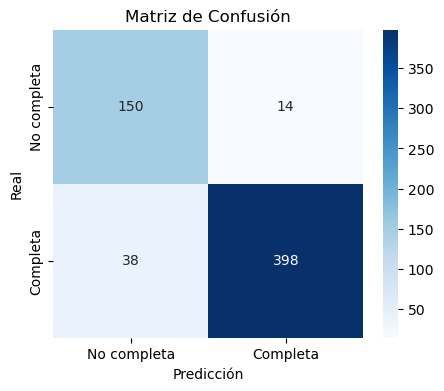

In [181]:
# Graficar la matriz de confusión con seaborn
plt.figure(figsize=(5, 4))
sns.heatmap(cm_rf, annot=True, fmt='g', cmap='Blues', xticklabels=["No completa", "Completa"], yticklabels=["No completa", "Completa"])
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")  
plt.show()

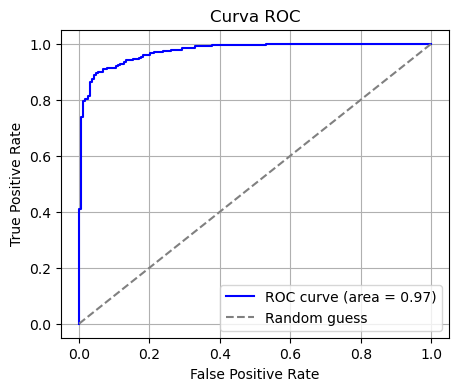

In [182]:
# Graficar la curva ROC
plt.figure(figsize=(5, 4))
plt.plot(fpr_rf, tpr_rf, color='blue', label=f'ROC curve (area = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

9. Mostramos las métricas del modelo

In [183]:
# Mostrar las métricas del modelo
print(f"F1-Score: {f1_rf:.3f}")
print(f"False Negative Rate: {fnr_rf:.3f}")
print(f"AUC-ROC: {roc_auc_rf:.3f}")
print(f"Puntuacion: {score_rf:.3f}")

F1-Score: 0.895
False Negative Rate: 0.086
AUC-ROC: 0.974
Puntuacion: 9.200


10. Agregar los resultados al dataframe de métricas

In [184]:
# Agregar las métricas al DataFrame con redondeo
new_row = pd.DataFrame({
    'Model': ['Random Forest Classifier'],
    'F1-Score': [round(f1_rf, 3)],
    'False Negative Rate': [round(fnr_rf, 3)],
    'AUC-ROC': [round(roc_auc_rf, 3)],
    'Puntuación modelo': [round(score_rf, 3)]
})

# Concatenar la nueva fila al DataFrame existente
metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

In [185]:
metrics_df

,Model,F1-Score,False Negative Rate,AUC-ROC,Puntuación modelo
0,Regresión lineal,0.887,0.095,0.946,9.087
1,SVM,0.865,0.093,0.936,9.051
2,KNN,0.898,0.092,0.959,9.144
3,Random Forest Classifier,0.895,0.086,0.974,9.200


# 5. LightGBM

In [84]:
# Cargar los datos
ds = pd.read_csv('datos_sinteticos.csv')

1. Importamos las librerías

In [186]:
import lightgbm as lgb

2. Separamos las variables predictoras de la variable objetivo

In [187]:
# Separar las características y la variable objetivo
X_lgb = ds.drop(columns = ['citorreduccion_completa'])  # Características
y_lgb = ds['citorreduccion_completa']  # Variable objetivo

3. Definimos el preprocesador

In [188]:
# Identificar columnas categóricas y numéricas
categorical_cols_lgb = ['Histología']
numerical_cols_lgb = X_lgb.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Configurar el preprocesador para características numéricas y categóricas
preprocessor_lgb = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[('scaler', StandardScaler())]), numerical_cols_lgb),
        ('cat', Pipeline(steps=[('onehot', OneHotEncoder(drop='first'))]), categorical_cols_lgb)
    ]
)

4. Creamos el pipeline

In [189]:
modelo_LGBM = lgb.LGBMClassifier(
    is_unbalance = True,
    n_estimators = 70, 
    max_depth= 6,
    learning_rate = 0.05,
    reg_alpha = 0.15, 
    reg_lambda = 0.1, 
    random_state = 1)

In [190]:
pipeline_lgb = Pipeline(steps=[
    ('preprocessor', preprocessor_lgb),  # Preprocesamiento de datos
    ('classifier', modelo_LGBM)  # Modelo LightGBM
])

5. Configurar validacion cruzada estratificada de k pliegues

In [191]:
# Configurar k-fold estratificado
k_lgb = 5  # Número de pliegues
skf_lgb = StratifiedKFold(n_splits = k_lgb, shuffle = True, random_state = 1)

6. Usamos la validación cruzada estratificada para realizar las predicciones6. 

In [192]:
# Cross-validation para obtener las predicciones con Random Forest
y_pred_lgb = cross_val_predict(pipeline_lgb, X_lgb, y_lgb, cv = skf_lgb, method = "predict")
y_pred_proba_lgb= cross_val_predict(pipeline_lgb, X_lgb, y_lgb, cv = skf_lgb, method = "predict_proba")[:, 1]

[LightGBM] [Info] Number of positive: 348, number of negative: 132
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 480, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.725000 -> initscore=0.969401
[LightGBM] [Info] Start training from score 0.969401
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[LightGBM] [Info] Number of positive: 348, number of negative: 132
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 480, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.725000 -> initscore=0.969401
[LightGBM] [Info] Start training from score 0.969401
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

7. Calculamos la matriz de confusión y las métricas. Visualizamos el informe de clasificación

In [193]:
# Calcular la matriz de confusión
cm_lgb = confusion_matrix(y_lgb, y_pred_lgb)

In [194]:
# F1-score
f1_lgb = f1_score(y_lgb, y_pred_lgb, average = 'macro')

In [195]:
# Cálculo de FNR para cada clase
fnr_lgb_class_1 = cm_lgb[1, 0] / (cm_lgb[1, 0] + cm_lgb[1, 1])  # Clase positiva: FN / (FN + TP)
fnr_lgb_class_0 = cm_lgb[0, 1] / (cm_lgb[0, 1] + cm_lgb[0, 0])  # Clase negativa: FN / (FN + TP)

# Media simple de los FNR
fnr_lgb = (fnr_lgb_class_1 + fnr_lgb_class_0) / 2

In [196]:
# Cálculo de la curva ROC y AUC
fpr_lgb, tpr_lgb, thresholds_lgb = roc_curve(y_lgb, y_pred_proba_lgb)
roc_auc_lgb = auc(fpr_lgb, tpr_lgb)

In [197]:
# Se calcula la puntuación en base a la función definida
score_lgb = puntuacion_modelo(fnr_lgb, f1_lgb, roc_auc_lgb)

In [198]:
# Generar el informe de clasificación
print("Informe de clasificación LightGBM:")
print(classification_report(y_lgb, y_pred_lgb))

Informe de clasificación LightGBM:
              precision    recall  f1-score   support

           0       0.82      0.91      0.87       164
           1       0.97      0.93      0.95       436

    accuracy                           0.92       600
   macro avg       0.90      0.92      0.91       600
weighted avg       0.93      0.92      0.92       600



8. Graficamos la matriz de confusión y la curva ROC

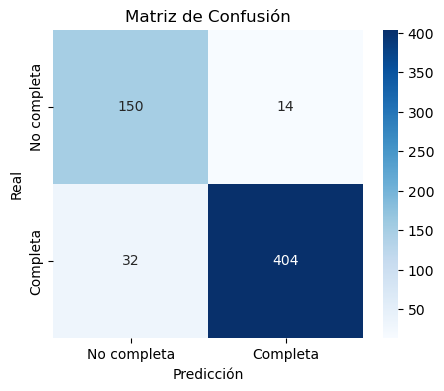

In [199]:
# Graficar la matriz de confusión con seaborn
plt.figure(figsize=(5, 4))
sns.heatmap(cm_lgb, annot=True, fmt='g', cmap='Blues', xticklabels=["No completa", "Completa"], yticklabels=["No completa", "Completa"])
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")  
plt.show()

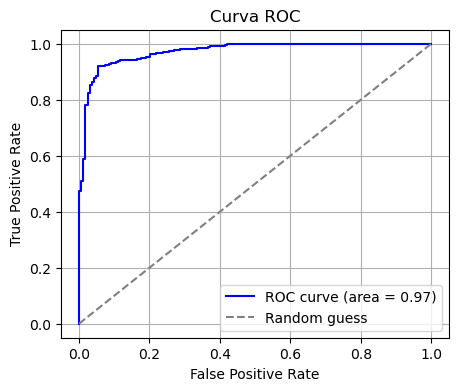

In [200]:
# Graficar la curva ROC
plt.figure(figsize=(5, 4))
plt.plot(fpr_lgb, tpr_lgb, color='blue', label=f'ROC curve (area = {roc_auc_lgb:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

9. Mostramos las métricas del modelo

In [201]:
# Mostrar las métricas del modelo
print(f"F1-Score: {f1_lgb:.3f}")
print(f"False Negative Rate: {fnr_lgb:.3f}")
print(f"AUC-ROC: {roc_auc_lgb:.3f}")
print(f"Puntuacion: {score_lgb:.3f}")

F1-Score: 0.907
False Negative Rate: 0.079
AUC-ROC: 0.972
Puntuacion: 9.262


10. Agregar los resultados al dataframe de métricas obtenidas

In [202]:
# Agregar las métricas al DataFrame con redondeo
new_row = pd.DataFrame({
    'Model': ['LightGBM'],
    'F1-Score': [round(f1_lgb, 3)],
    'False Negative Rate': [round(fnr_lgb, 3)],
    'AUC-ROC': [round(roc_auc_lgb, 3)],
    'Puntuación modelo': [round(score_lgb, 3)]
})

# Concatenar la nueva fila al DataFrame existente
metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

In [203]:
metrics_df

,Model,F1-Score,False Negative Rate,AUC-ROC,Puntuación modelo
0,Regresión lineal,0.887,0.095,0.946,9.087
1,SVM,0.865,0.093,0.936,9.051
2,KNN,0.898,0.092,0.959,9.144
3,Random Forest Classifier,0.895,0.086,0.974,9.200
4,LightGBM,0.907,0.079,0.972,9.262


# 6. Redes neuronales profundas

In [103]:
import pandas as pd

In [104]:
# Cargar los datos
ds = pd.read_csv('datos_sinteticos.csv')

1. Importamos las librerías

In [204]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split

2. Dividimos en variables predictoras y variable objetivo

In [205]:
# Variable objetivo y características
X_nn = ds.drop(columns = ['citorreduccion_completa'])  # Características
y_nn = ds['citorreduccion_completa']  # Variable objetivo

3. Definimos el preprocesador

In [206]:
categorical_cols_nn = ['Histología']
numerical_cols_nn = X_nn.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Configurar el preprocesador para características numéricas y categóricas
preprocessor_nn = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[('scaler', StandardScaler())]), numerical_cols_nn),
        ('cat', Pipeline(steps=[('onehot', OneHotEncoder(drop = 'first'))]), categorical_cols_nn)
    ]
)

4. Calculamos el nuevo numero de características

In [207]:
# Obtener número de características después del preprocesamiento
preprocessor_nn.fit(X_nn)  
n_features = preprocessor_nn.transform(X_nn).shape[1]

5. Definimos una función para crear el modelo

In [208]:
def crear_modelo_nn():
    modelo_nn = Sequential([
        Input(shape=(n_features,)),  # Se obtiene previamente
        Dense(64, activation='relu', kernel_regularizer = l2(0.01)),  # Primera capa oculta
        Dropout(0.3),
        Dense(32, activation='relu', kernel_regularizer=l2(0.01)),  # Segunda capa oculta
        Dropout(0.25),
        Dense(1, activation='sigmoid')  # Capa de salida
    ])
    modelo_nn.compile(optimizer = Adam(),
                  loss = 'binary_crossentropy',
                  metrics = ['accuracy'])
    return modelo_nn

6. Creamos el clasificador

In [209]:
classifier_nn = KerasClassifier(
    model = crear_modelo_nn, 
    epochs = 15, 
    batch_size = 32, 
    verbose = 0)

7. Creamos el pipeline

In [210]:
pipeline_nn = Pipeline(steps=[
    ('preprocessor', preprocessor_nn),
    ('classifier', classifier_nn) 
])

8. Definimos la validación cruzada estratificada

In [211]:
k_nn = 5  # Número de pliegues
skf_nn = StratifiedKFold(n_splits = k_nn, shuffle = True, random_state = 1)

9. Pedecimos con la validación cruzada

In [212]:
# Validación cruzada con predicción
y_pred_nn = cross_val_predict(pipeline_nn, X_nn, y_nn, cv = skf_nn, method="predict")
y_pred_proba_nn = cross_val_predict(pipeline_nn, X_nn, y_nn, cv = skf_nn, method="predict_proba")[:, 1]

10. Calculamos las métricas ymostramos el informe de clasificación

In [213]:
# Calcular la matriz de confusión
cm_nn = confusion_matrix(y_nn, y_pred_nn)

# F1-score ponderado
f1_nn = f1_score(y_nn, y_pred_nn, average='macro')

# Cálculo de FNR para cada clase
fnr_nn_class_1 = cm_nn[1, 0] / (cm_nn[1, 0] + cm_nn[1, 1])  # Clase positiva
fnr_nn_class_0 = cm_nn[0, 1] / (cm_nn[0, 1] + cm_nn[0, 0])  # Clase negativa
# Media simple de los FNR
fnr_nn = (fnr_nn_class_1 + fnr_nn_class_0) / 2

# AUC-ROC
fpr_nn, tpr_nn, thresholds_nn = roc_curve(y_nn, y_pred_proba_nn)
roc_auc_nn = auc(fpr_nn, tpr_nn)

# Función personalizada para calcular el puntaje final (debes definirla previamente)
score_nn = puntuacion_modelo(fnr_nn, f1_nn, roc_auc_nn)

In [214]:
# Generar el informe de clasificación
print("Informe de clasificación Red neuronal:")
print(classification_report(y_nn, y_pred_nn))

Informe de clasificación Red neuronal:
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       164
           1       0.95      0.92      0.94       436

    accuracy                           0.91       600
   macro avg       0.88      0.90      0.89       600
weighted avg       0.91      0.91      0.91       600



11. Mostramos la matriz de confusión y la curva ROC

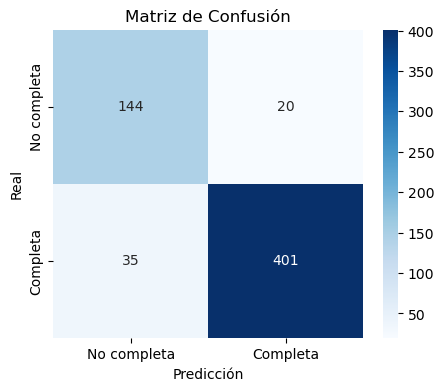

In [215]:
# Graficar la matriz de confusión con seaborn
plt.figure(figsize=(5, 4))
sns.heatmap(cm_nn, annot=True, fmt='g', cmap='Blues', xticklabels=["No completa", "Completa"], yticklabels=["No completa", "Completa"])
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")  
plt.show()

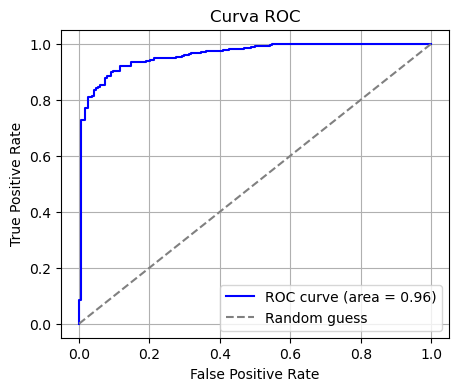

In [216]:
# Graficar la curva ROC
plt.figure(figsize=(5, 4))
plt.plot(fpr_nn, tpr_nn, color='blue', label=f'ROC curve (area = {roc_auc_nn:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

11. Mostramos las métricas obtenidas

In [217]:
# Mostrar las métricas del modelo
print(f"F1-Score: {f1_nn:.3f}")
print(f"False Negative Rate: {fnr_nn:.3f}")
print(f"AUC-ROC: {roc_auc_nn:.3f}")
print(f"Puntuacion: {score_nn:.3f}")

F1-Score: 0.888
False Negative Rate: 0.101
AUC-ROC: 0.960
Puntuacion: 9.064


12. Se añaden los resultados al dataframe de métricas

In [218]:
# Agregar las métricas al DataFrame con redondeo
new_row = pd.DataFrame({
    'Model': ['Red neuronal'],
    'F1-Score': [round(f1_nn, 3)],
    'False Negative Rate': [round(fnr_nn, 3)],
    'AUC-ROC': [round(roc_auc_nn, 3)],
    'Puntuación modelo': [round(score_nn, 3)]
})

# Concatenar la nueva fila al DataFrame existente
metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

In [219]:
metrics_df

,Model,F1-Score,False Negative Rate,AUC-ROC,Puntuación modelo
0,Regresión lineal,0.887,0.095,0.946,9.087
1,SVM,0.865,0.093,0.936,9.051
2,KNN,0.898,0.092,0.959,9.144
3,Random Forest Classifier,0.895,0.086,0.974,9.200
4,LightGBM,0.907,0.079,0.972,9.262
5,Red neuronal,0.888,0.101,0.960,9.064


# Exportación del mejor modelo

Exportamos el pipeline que incluye el preprocesador, antes de exportarlo lo entrenamos con .fit()

In [121]:
import pickle

In [122]:
# Entrenar el pipeline antes de exportarlo
pipeline_lgb.fit(X_lgb, y_lgb)

[LightGBM] [Info] Number of positive: 436, number of negative: 164
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000842 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1028
[LightGBM] [Info] Number of data points in the train set: 600, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.726667 -> initscore=0.977776
[LightGBM] [Info] Start training from score 0.977776
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['MTV_INFRADIA_TOTAL',
                                                   'GLSUPR_MTV',
                                                   'TLG_INFRADIA_TOTAL',
                                                   'GLSUPR_TLG',
                                                   'SUVMAX_LIQASC', 'Edad',
                                                   'MTV_TOTAL', 'TLG_TOTAL']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['Histología'])])),
                ('classifier',
                 LGBMClassifier(is_unbalance=True, learning_rate=0.05,
                                max_depth=6, n_estimators=70, random_state=1,
                                reg_alpha=0.15, reg_lambda=0.1))])

In [123]:
# Guardar el pipeline en un archivo
with open('pipeline_lgb.pkl', 'wb') as file:
    pickle.dump(pipeline_lgb, file)